# **TAREA 12 - VISIÓN DE MÁQUINA**
## **Clasificadores probabilísticos**
**Universidad Nacional de Colombia** <br>
**Maestría en Ingeniería - Automatización industrial**

Juan Sebastián Hernandez Reyes; Julián Felipe Molina Grisales

In [2]:
#Importar las librerias necesarias
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons, make_circles, make_blobs
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier, KernelDensity

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score

## 1. Para datos de su proyecto, comparar el desempeño de las tres técnicas de clasificación presentadas.


*   Naive Bayes
*   Método de la ventana de Parzen
*   K-vecinos más cercanos
---

---



Ya que en el proyecto no se trabajo con métodos "clásicos", no se tienen datos específicos del proyecto para probar en la clasificación, por lo que se usaran datos sintéticos obtenidos de la libreria de ``scikit-learn``, se usaran 3 distribuciones de datos diferentes para probar con los diferentes clasificadores

In [35]:
datasets = [make_moons(n_samples=250,noise=0.2, random_state=0),
            make_circles(n_samples=250, factor=.5, noise=.2),
            make_blobs(n_samples=250, centers=2)]

Para usar el método de la ventana de Parzen (Mejor conocido como al estimación de densidad por Kernel - KDE), el cual mas que un método de clasificación es un método de estimación de una función de densidad de probabilidad, se procede a construir un clasificador parecido al clasificador Gaussiano (Naive Bayes) que use el mismo principio pero que no asuma que la distribución de todos los datos es normal, sino es la estimada por el KDE. Esta implementación es obtenida de [5]

In [8]:
class KDEClassifier(BaseEstimator, ClassifierMixin):
  """Bayesian generative classification based on KDE
  
  Parameters
  ----------
  bandwidth : float
      the kernel bandwidth within each class
  kernel : str
      the kernel name, passed to KernelDensity
  """
  def __init__(self, bandwidth=1.0, kernel='gaussian'):
    self.bandwidth = bandwidth
    self.kernel = kernel
      
  def fit(self, X, y):
    self.classes_ = np.sort(np.unique(y))
    training_sets = [X[y == yi] for yi in self.classes_]
    self.models_ = [KernelDensity(bandwidth=self.bandwidth,
                                  kernel=self.kernel).fit(Xi)
                    for Xi in training_sets]
    self.logpriors_ = [np.log(Xi.shape[0] / X.shape[0])
                        for Xi in training_sets]
    return self
      
  def predict_proba(self, X):
    logprobs = np.array([model.score_samples(X)
                          for model in self.models_]).T
    result = np.exp(logprobs + self.logpriors_)
    return result / result.sum(1, keepdims=True)
      
  def predict(self, X):
    return self.classes_[np.argmax(self.predict_proba(X), 1)]

Se define ademas una función que permita graficar los resultados de los clasificadores en un workspace determinado

In [56]:
def plotRegion(X,y,classifiers):
  names = ['Clasificador Gaussiano','Clasificador usando KDE',
           'Clasificador usando k-vecinos']
  maxX1 = np.amax(X[:,0])+abs(np.amax(X[:,0]))*0.1
  maxX2 = np.amax(X[:,1])+abs(np.amax(X[:,1]))*0.1
  minX1 = np.amin(X[:,0])-abs(np.amin(X[:,0]))*0.1
  minX2 = np.amin(X[:,1])-abs(np.amin(X[:,1]))*0.1
  x1 = np.linspace(minX1, maxX1, 150,endpoint=True)
  x2 = np.linspace(minX2, maxX2, 150,endpoint=True)
  XX, YY = np.meshgrid(x1, x2)
  fig, axs = plt.subplots(1, len(classifiers),figsize = [15,5])
  for p in range(3):
    Z = np.zeros((x1.shape[0],x2.shape[0]))

    for i in range(len(x1)):
        for j in range(len(x2)):
          pt=np.array([[x1[i],x2[j]]])
          Z[j,i] = classifiers[p].predict(pt)

    axs[p].plot(X[(y==1),0], X[(y==1),1], 'ro')
    axs[p].plot(X[(y==0),0], X[(y==0),1], 'b^')
    axs[p].pcolormesh(XX, YY, Z, cmap = plt.cm.coolwarm, vmin=-1, vmax=2)
    axs[p].contour(XX,YY,Z, linewidths=2,colors='black')
    axs[p].set_title(names[p])
  plt.show()

Usando el dataset make_moons


Accuracy del clasificador gaussiano: 0.78
Accuracy del clasificador usando KDE: 0.8
Accuracy del clasificador k-vecinos: 0.86
----------------------------------------


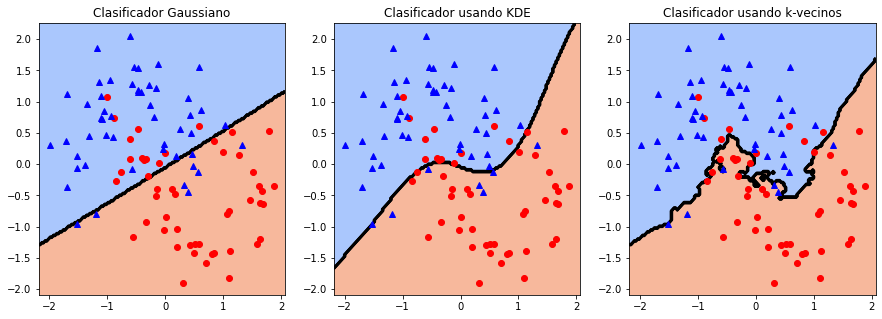

Usando el dataset make_circles


Accuracy del clasificador gaussiano: 0.84
Accuracy del clasificador usando KDE: 0.91
Accuracy del clasificador k-vecinos: 0.93
----------------------------------------


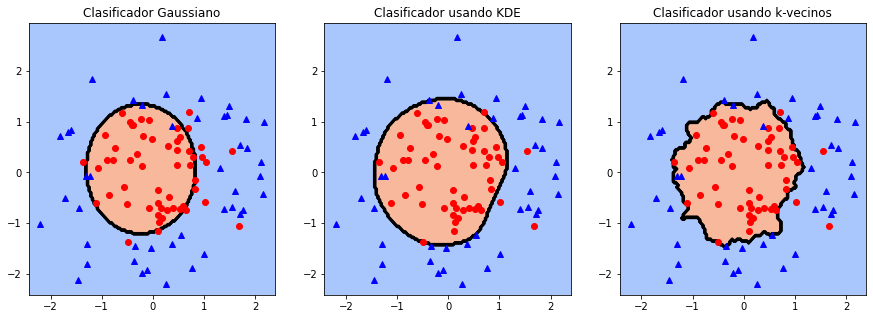

Usando el dataset make_blobs


Accuracy del clasificador gaussiano: 1.0
Accuracy del clasificador usando KDE: 1.0
Accuracy del clasificador k-vecinos: 1.0
----------------------------------------


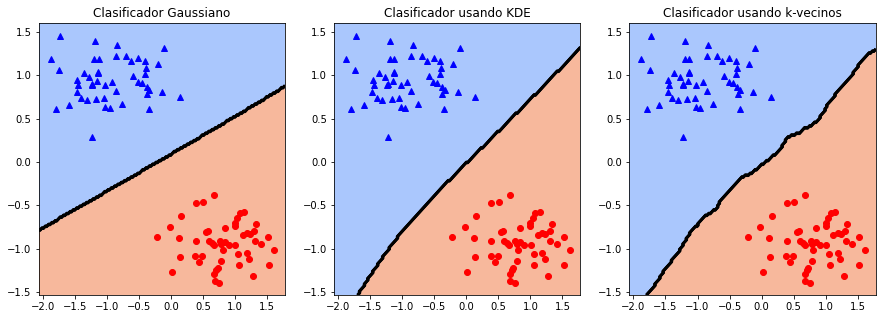

In [63]:
# Ahora se va a iterar cada clasificador en los diferentes datasets, donde se 
#plotean sus regiones de clasificación y el accuracy de cada clasificador

datasets_name = ['make_moons','make_circles','make_blobs']

for i, (X, y) in enumerate(datasets):
  
  # Preprocesar el dataset, diviendolo en entrenamiento y validación
  X = StandardScaler().fit_transform(X)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4)

  print('Usando el dataset ' + datasets_name[i])
  print('\n')

  #Clasificador gaussiano (Naive Bayes)
  gnb = GaussianNB()
  gnb = gnb.fit(X_train, y_train)
  y_pred = gnb.predict(X_test)
  
  print('Accuracy del clasificador gaussiano: '+ str(accuracy_score(y_test,y_pred)))

  #Clasificador con el método de la ventana de Parzen (KDE)
  kde = KDEClassifier(bandwidth=0.5)
  kde = kde.fit(X_train, y_train)
  y_pred = kde.predict(X_test)

  print('Accuracy del clasificador usando KDE: ' + str(accuracy_score(y_test,y_pred)))

  #K vecinos mas cercanos
  kmeans = KNeighborsClassifier(n_neighbors=12)
  kmeans = kmeans.fit(X_train,y_train) 
  y_pred = kmeans.predict(X_test)

  print('Accuracy del clasificador k-vecinos: ' + str(accuracy_score(y_test,y_pred)))
  print('-'*40)
  plotRegion(X_test,y_test,[gnb,kde,kmeans])

En rangos generañes, el clasificador de k-medias obtuvo el mejor desempeño, seguido por el clasificador KDE y por último el clasificador Gaussiano

Se puede observar que el clasificador Gaussiano siempre genera una frontera de clasificación lineal, lo cual es esperado debido a que este es construido usando la formula de Bayes y la distribución normal; cuando se pasa al clasificador KDE se observa que este ya es capaz de generar una frontera de clasificación no lineal, debido a que el algoritmo tambien aprende cual es la distribución de probabilidad que mas se ajuste a los datos obtenidos, esto mejora la clasificación, pero cabe resaltar que este clasificador en muy sensible al parámetro de ancho de banda (se hizo un ajuste por encima de este); finalmente con el algoritmo de k-medias se observa que la frontera tiende a ser mucho menos suave, esto probablemente por los clusters que genera el algoritmo.

## Referencias

1.   Notas de clase y presentaciones. Visión de máquina. 2021-I.
2.   Intro to Scikit-learn’s k-Nearest-Neighbors Classifier And Regressor. Medium. 2020. Available [here](https://towardsdatascience.com/intro-to-scikit-learns-k-nearest-neighbors-classifier-and-regressor-4228d8d1cba6)
3.   Using Kernel Density Estimates for Exploratory Data Analysis. Medium. 2021. Available [here](https://medium.com/the-data-science-publication/using-kernel-density-estimates-for-exploratory-data-analysis-15ee56a044d6)

4.   How to find the optimal value of K in KNN?. Medium. 2020. Available [here](https://towardsdatascience.com/how-to-find-the-optimal-value-of-k-in-knn-35d936e554eb#:~:text=K%20value%20indicates%20the%20count,is%20a%20lazy%20learning%20algorithm.)

5.   In-Depth: Kernel Density Estimation. Python Data Science Handbook. Available [here](https://jakevdp.github.io/PythonDataScienceHandbook/05.13-kernel-density-estimation.html)

6. Kernel density estimation examples from ``scikit-learn`` API. [Kernel Density Estimation as generative model](https://scikit-learn.org/stable/auto_examples/neighbors/plot_digits_kde_sampling.html#sphx-glr-auto-examples-neighbors-plot-digits-kde-sampling-py) and [Simple 1D Kernel Density Estimation](https://scikit-learn.org/stable/auto_examples/neighbors/plot_kde_1d.html#sphx-glr-auto-examples-neighbors-plot-kde-1d-py)